In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import sys
import gc

%matplotlib inline

In [1]:
train_path = 'data/sales_train_validation.csv'
submission_path = 'data/sample_submission.csv'
calendar_path = 'data/calendar.csv' 
sell_prices_path = 'data/sell_prices.csv'

In [3]:
plt.rcParams["figure.figsize"] = 14, 6
sns.set()

In [4]:
def rmse(y_true, y_pred):
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Objectives
The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 42,840 time series of the competition. I addition, to elicit information to estimate the uncertainty distribution of the realized values of these series as precisely as possible. 
To that end, the participants of M5 are asked to provide 28 days ahead point forecasts (PFs) for all the series of the competition, as well as the corresponding median and 50%, 67%, 95%, and 99% prediction intervals (PIs).
The M5 differs from the previous four ones in five important ways, some of them suggested by the discussants of the M4  competition, as follows:
- First, it uses grouped unit sales data, starting at the product-store level and being aggregated to that of product departments, product categories, stores, and three geographical areas: the States of California (CA), Texas (TX), and Wisconsin (WI).
- Second, besides the time series data, it includes explanatory variables such as sell prices, promotions, days of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that typically affect unit sales and could improve forecasting accuracy.
- Third, in addition to point forecasts, it assesses the distribution of uncertainty, as the participants are asked to provide information on nine indicative quantiles.
- Fourth, instead of having a single competition to estimate both the point forecasts and the uncertainty distribution, there will be two parallel tracks using the same dataset, the first requiring 28 days ahead point forecasts and the second 28 days ahead probabilistic forecasts for the median and four prediction intervals (50%, 67%, 95%, and 99%).
- Fifth, for the first time it focuses on series that display intermittency, i.e., sporadic demand including zeros.

## Datasets info
The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI)

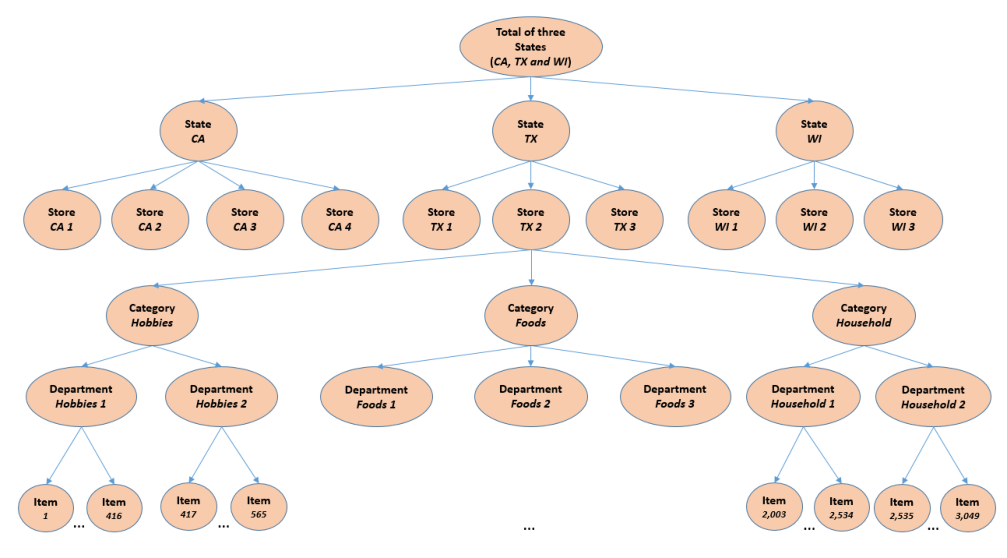

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sns.set()
plt.rcParams["figure.figsize"] = 20, 10

img = mpimg.imread("../data/m5-forecasting-accuracy/m5-forecasting-hierarchical.png")
imgplot = plt.imshow(img)
plt.grid(False)
plt.axis("off")
plt.show()

Remove outlier days: Xmas

In [6]:
plt.rcParams["figure.figsize"] = 14, 6

Model choice
- I decide to turn the time series problem into a supervised learning problem
- Reasons:
    - There's no existing package (that I know of) for time series analysis and forecast capable of dealing of this much amount of time series (statsmodels can only fit one series at a time)
    - It's more straight forward to incorporate external features 
    - Random Forests and LightGBM are powerful algorithm that do really well in many types of problem, including time series forecast

- Model 1:
    - Existing Features
    - 28 days at once
- Model 2:
    - Existing + New (Meaningful) Features
    - 28, 7, 1 
    - Average
- Enhance 3
    - Existing + New (All) Features
    - 28, 7, 1 
    - Average
    
- Note: Find a way to check learning curve and train vs val score
- Split the data into 3
    - train
    - val
    - test

In [7]:
def split_data(data, target_col, feature_cols, n_vals):
    """ Split data in train, val, test sets """
    all_d = data['d'].unique()
    
    # Get days for test, val, and train sets
    test_d = all_d[-n_vals:]
    val_d = np.random.choice(np.setdiff1d(all_d, test_d), n_vals)
    train_d = np.setdiff1d(all_d, np.append(val_d, test_d))

    # Make sure we don't drop any days
    assert np.setdiff1d(all_d, np.concatenate([val_d, test_d, train_d])).size == 0
    
    # Subset dataframe
    val, test, train = data.query('d in @val_d'), data.query('d in @test_d'), data.query('d in @train_d')
    assert val.shape[0] + test.shape[0] + train.shape[0] == sales.shape[0]

    # Split data
    X_train, y_train = train[feature_cols], train[target_col]
    X_val, y_val = val[feature_cols], val[target_col]
    X_test, y_test = test[feature_cols], test[target_col]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

## Model 1

In [8]:
model_name = 'model_1.model'
data_name = 'sales_1.feather'

#### Get existing features

In [9]:
sales = pd.read_feather(data_name)
sales['d'] = sales['d'].astype(int)
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale,wday,month,year,snap_CA,snap_TX,snap_WI,quarter
0,1437,3,1,0,0,1112,0,6,2,2014,0,1,0,1
1,1438,3,1,0,0,1112,0,6,2,2014,0,1,0,1
2,1439,3,1,0,0,1112,0,6,2,2014,0,1,0,1
3,1440,3,1,0,0,1112,3,6,2,2014,0,1,0,1
4,1441,3,1,0,0,1112,1,6,2,2014,0,1,0,1


In [10]:
target_col = 'sale'
feature_cols = np.setdiff1d(sales.columns, target_col)

n_vals = 28

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sales, target_col, feature_cols, n_vals)

del sales
gc.collect();

In [11]:
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [12]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

In [13]:
%%time

try:
    model = lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 
    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 2.40461	validation's rmse: 2.54304
[200]	train's rmse: 2.32388	validation's rmse: 2.45858
[300]	train's rmse: 2.2727	validation's rmse: 2.4109
[400]	train's rmse: 2.23393	validation's rmse: 2.37718
[500]	train's rmse: 2.20503	validation's rmse: 2.3535
[600]	train's rmse: 2.17189	validation's rmse: 2.32431
[700]	train's rmse: 2.14619	validation's rmse: 2.30074
[800]	train's rmse: 2.12555	validation's rmse: 2.28078
[900]	train's rmse: 2.10694	validation's rmse: 2.26548
[1000]	train's rmse: 2.08975	validation's rmse: 2.2494
[1100]	train's rmse: 2.074	validation's rmse: 2.236
[1200]	train's rmse: 2.05778	validation's rmse: 2.22263
Wall time: 38min


In [14]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_1.model: 2.113476444391008


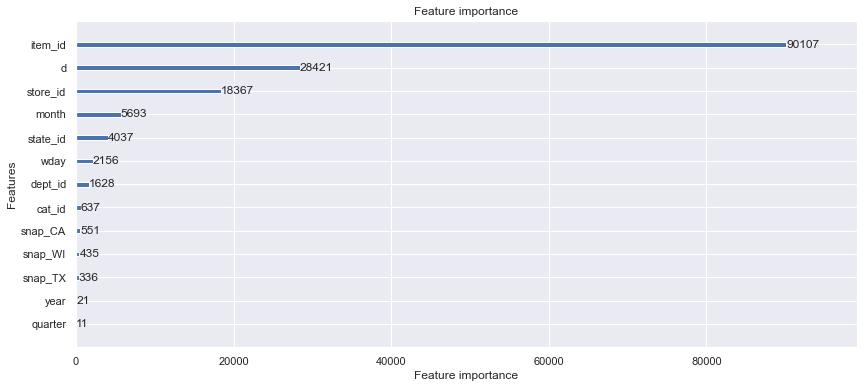

In [15]:
lgb.plot_importance(model)

## Model 2

In [16]:
model_name = 'model_2.model'
data_name = 'sales_2.feather'

#### Get existing features

In [17]:
sales = pd.read_feather(data_name)
sales['d'] = sales['d'].astype(int)
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale,wday,month,year,snap_CA,snap_TX,snap_WI,quarter,lag1,lag7,lag28,lag365
0,1437,3,1,0,0,1478,3,1,2,2015,0,0,1,1,3.0,2.0,1.0,0.0
1,1438,3,1,0,0,1478,0,1,2,2015,0,0,1,1,0.0,0.0,0.0,0.0
2,1439,3,1,0,0,1478,0,1,2,2015,0,0,1,1,0.0,0.0,0.0,0.0
3,1440,3,1,0,0,1478,4,1,2,2015,0,0,1,1,1.0,10.0,2.0,3.0
4,1441,3,1,0,0,1478,1,1,2,2015,0,0,1,1,1.0,5.0,1.0,1.0


In [18]:
target_col = 'sale'
feature_cols = np.setdiff1d(sales.columns, target_col)

n_vals = 28

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sales, target_col, feature_cols, n_vals)

del sales
gc.collect();

In [19]:
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [20]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

In [21]:
%%time

try:
    lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 

    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 2.04993	validation's rmse: 2.0748
[200]	train's rmse: 2.00328	validation's rmse: 2.04735
[300]	train's rmse: 1.97775	validation's rmse: 2.03387
[400]	train's rmse: 1.9553	validation's rmse: 2.02375
[500]	train's rmse: 1.93647	validation's rmse: 2.01834
[600]	train's rmse: 1.91945	validation's rmse: 2.0134
[700]	train's rmse: 1.90481	validation's rmse: 2.00935
[800]	train's rmse: 1.89159	validation's rmse: 2.00634
[900]	train's rmse: 1.87836	validation's rmse: 2.00316
[1000]	train's rmse: 1.86597	validation's rmse: 2.00069
[1100]	train's rmse: 1.85341	validation's rmse: 1.99783
[1200]	train's rmse: 1.84133	validation's rmse: 1.99576
Wall time: 30min 25s


In [22]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_2.model: 2.010913930324161


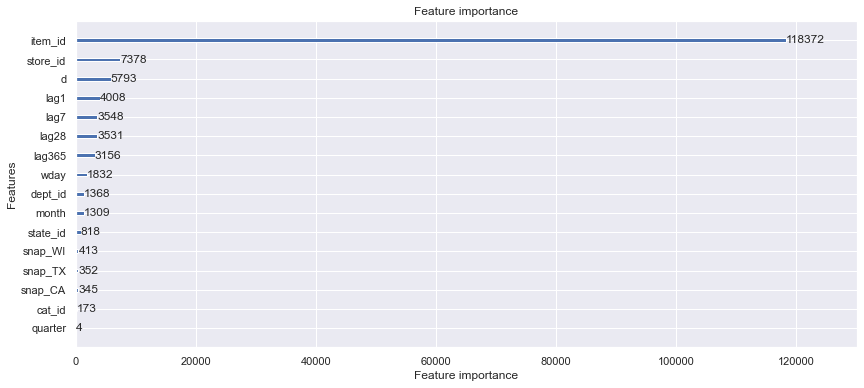

In [23]:
lgb.plot_importance(model)

## Model 3

In [24]:
model_name = 'model_3.model'
data_name = 'sales_3.feather'

#### Get existing features

In [25]:
sales = pd.read_feather(data_name)
sales['d'] = sales['d'].astype(int)
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale,wday,month,year,...,lag1,lag7,lag28,lag365,ma7_lag1,ma28_lag1,ma7_lag7,ma28_lag7,ma7_lag28,ma28_lag28
0,1437,3,1,0,0,1505,0,7,3,2015,...,1.0,1.0,3.0,0.0,0.857143,0.785714,0.571429,0.750000,1.000000,0.678571
1,1438,3,1,0,0,1505,0,7,3,2015,...,0.0,0.0,0.0,0.0,0.142857,0.142857,0.285714,0.107143,0.000000,0.071429
2,1439,3,1,0,0,1505,1,7,3,2015,...,1.0,0.0,0.0,0.0,0.142857,0.392857,0.571429,0.428571,0.285714,0.357143
3,1440,3,1,0,0,1505,1,7,3,2015,...,0.0,1.0,1.0,1.0,2.428571,2.428571,1.571429,2.464286,2.571429,2.428571
4,1441,3,1,0,0,1505,2,7,3,2015,...,1.0,1.0,1.0,0.0,1.142857,1.214286,1.142857,1.285714,1.428571,1.107143


In [26]:
target_col = 'sale'
feature_cols = np.setdiff1d(sales.columns, target_col)

n_vals = 28

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sales, target_col, feature_cols, n_vals)

del sales
gc.collect();

In [27]:
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [28]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

In [29]:
%%time

try:
    lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 

    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 1.96269	validation's rmse: 2.02335
[200]	train's rmse: 1.93053	validation's rmse: 2.01662
[300]	train's rmse: 1.91051	validation's rmse: 2.00955
[400]	train's rmse: 1.89365	validation's rmse: 2.00566
[500]	train's rmse: 1.87907	validation's rmse: 2.00268
[600]	train's rmse: 1.86195	validation's rmse: 1.999
[700]	train's rmse: 1.84821	validation's rmse: 1.99711
[800]	train's rmse: 1.83604	validation's rmse: 1.99631
[900]	train's rmse: 1.82463	validation's rmse: 1.99474
[1000]	train's rmse: 1.8126	validation's rmse: 1.99386
[1100]	train's rmse: 1.80262	validation's rmse: 1.99214
[1200]	train's rmse: 1.79344	validation's rmse: 1.99141
Wall time: 31min 20s


In [30]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_3.model: 1.9509425040364885


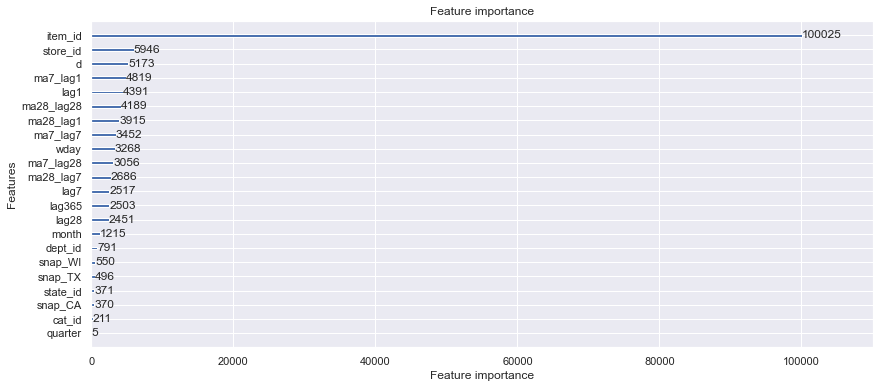

In [31]:
lgb.plot_importance(model)

## Model 4

In [32]:
model_name = 'model_4.model'
data_name = 'sales_4.feather'

#### Get existing features

In [33]:
sales = pd.read_feather(data_name)
sales['d'] = sales['d'].astype(int)
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale,sell_price,price_change,price_change_mean,...,lag1,lag7,lag28,lag365,ma7_lag1,ma28_lag1,ma7_lag7,ma28_lag7,ma7_lag28,ma28_lag28
0,1437,3,1,0,0,1478,3,8.26,0.0,-0.007792,...,3.0,2.0,1.0,0.0,0.428571,0.678571,0.428571,0.678571,0.857143,0.785714
1,1438,3,1,0,0,1478,0,3.97,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.142857,0.071429,0.142857,0.142857,0.285714,0.571429
2,1439,3,1,0,0,1478,0,2.97,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.142857,0.357143,0.142857,0.357143,0.285714,0.142857
3,1440,3,1,0,0,1478,4,4.64,0.0,0.001083,...,1.0,10.0,2.0,3.0,3.000000,2.428571,3.000000,2.750000,2.714286,2.357143
4,1441,3,1,0,0,1478,1,2.88,0.0,-0.000376,...,1.0,5.0,1.0,1.0,1.428571,1.107143,1.428571,1.071429,0.714286,1.071429


In [34]:
target_col = 'sale'
feature_cols = np.setdiff1d(sales.columns, target_col)

n_vals = 28

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sales, target_col, feature_cols, n_vals)

del sales
gc.collect();

In [35]:
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

In [36]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

In [37]:
%%time

try:
    lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 

    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 1.99891	validation's rmse: 2.12447
[200]	train's rmse: 1.96111	validation's rmse: 2.11295
[300]	train's rmse: 1.94072	validation's rmse: 2.1057
[400]	train's rmse: 1.92377	validation's rmse: 2.10113
[500]	train's rmse: 1.90707	validation's rmse: 2.09709
[600]	train's rmse: 1.89271	validation's rmse: 2.0933
[700]	train's rmse: 1.87737	validation's rmse: 2.09033
[800]	train's rmse: 1.86379	validation's rmse: 2.08909
[900]	train's rmse: 1.85318	validation's rmse: 2.08855
[1000]	train's rmse: 1.84098	validation's rmse: 2.08688
[1100]	train's rmse: 1.83249	validation's rmse: 2.08623
[1200]	train's rmse: 1.82235	validation's rmse: 2.08534
Wall time: 32min 38s


In [38]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_4.model: 2.0006315458160646


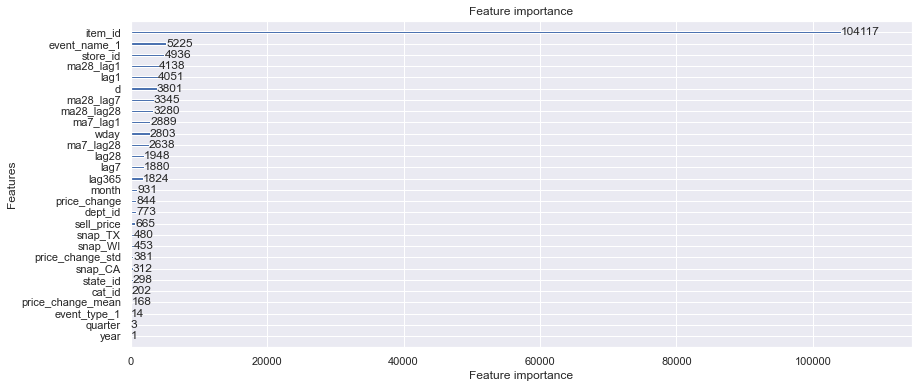

In [39]:
lgb.plot_importance(model)

In [42]:
model_name = 'model_4_1'

In [46]:
%%time

try:
    lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 

    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 1.9995	validation's rmse: 2.12338
[200]	train's rmse: 1.96411	validation's rmse: 2.11379
[300]	train's rmse: 1.94387	validation's rmse: 2.10827
[400]	train's rmse: 1.92429	validation's rmse: 2.10456
[500]	train's rmse: 1.90846	validation's rmse: 2.10177
[600]	train's rmse: 1.89379	validation's rmse: 2.09868
[700]	train's rmse: 1.87826	validation's rmse: 2.09604
[800]	train's rmse: 1.86468	validation's rmse: 2.09436
[900]	train's rmse: 1.85124	validation's rmse: 2.09166
[1000]	train's rmse: 1.84241	validation's rmse: 2.09084
[1100]	train's rmse: 1.83381	validation's rmse: 2.08936
[1200]	train's rmse: 1.82369	validation's rmse: 2.08793
Wall time: 33min 51s


In [47]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_4_1: 2.001778263119441


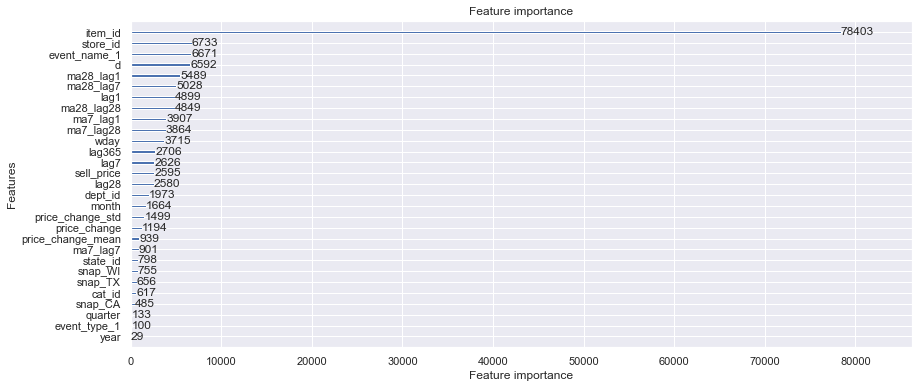

In [48]:
lgb.plot_importance(model)

## Model 5

In [49]:
model_name = 'model_5.model'
data_name = 'sales_3.feather'

#### Get existing features

In [50]:
sales = pd.read_feather(data_name)
sales['d'] = sales['d'].astype(int)
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sale,wday,month,year,...,lag1,lag7,lag28,lag365,ma7_lag1,ma28_lag1,ma7_lag7,ma28_lag7,ma7_lag28,ma28_lag28
0,1437,3,1,0,0,1505,0,7,3,2015,...,1.0,1.0,3.0,0.0,0.857143,0.785714,0.571429,0.750000,1.000000,0.678571
1,1438,3,1,0,0,1505,0,7,3,2015,...,0.0,0.0,0.0,0.0,0.142857,0.142857,0.285714,0.107143,0.000000,0.071429
2,1439,3,1,0,0,1505,1,7,3,2015,...,1.0,0.0,0.0,0.0,0.142857,0.392857,0.571429,0.428571,0.285714,0.357143
3,1440,3,1,0,0,1505,1,7,3,2015,...,0.0,1.0,1.0,1.0,2.428571,2.428571,1.571429,2.464286,2.571429,2.428571
4,1441,3,1,0,0,1505,2,7,3,2015,...,1.0,1.0,1.0,0.0,1.142857,1.214286,1.142857,1.285714,1.428571,1.107143


In [51]:
target_col = 'sale'
feature_cols = np.setdiff1d(sales.columns, target_col)

n_vals = 28

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sales, target_col, feature_cols, n_vals)

del sales
gc.collect();

In [52]:
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [53]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)

In [54]:
%%time

try:
    lgb.Booster(model_file=model_name)
    
except lgb.engine.LightGBMError:
    
    params = {
        "objective": "poisson",
        "metric": "rmse",
        "force_row_wise": True,
        "learning_rate": 0.075,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "lambda_l2": 0.1,
        "metric": ["rmse"],
        "verbosity": 1,
        "num_iterations": 1200,
        "num_leaves": 128,
        "min_data_in_leaf": 100,
    }

    model = lgb.train(params, train_data, valid_sets=[train_data, val_data], valid_names=['train', 'validation'], verbose_eval=100) 

    model.save_model(model_name)

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	train's rmse: 1.96893	validation's rmse: 2.02143
[200]	train's rmse: 1.93404	validation's rmse: 2.00922
[300]	train's rmse: 1.91336	validation's rmse: 1.99708
[400]	train's rmse: 1.89579	validation's rmse: 1.98976
[500]	train's rmse: 1.87933	validation's rmse: 1.98447
[600]	train's rmse: 1.86242	validation's rmse: 1.97957
[700]	train's rmse: 1.84935	validation's rmse: 1.97681
[800]	train's rmse: 1.83589	validation's rmse: 1.97442
[900]	train's rmse: 1.82449	validation's rmse: 1.9723
[1000]	train's rmse: 1.81392	validation's rmse: 1.97164
[1100]	train's rmse: 1.80468	validation's rmse: 1.97077
[1200]	train's rmse: 1.79587	validation's rmse: 1.97009
Wall time: 32min 23s


In [55]:
y_pred = model.predict(X_test)

print(f'RMSE for {model_name}:', rmse(y_test, y_pred))

RMSE for model_3_1.model: 1.9593796462993522


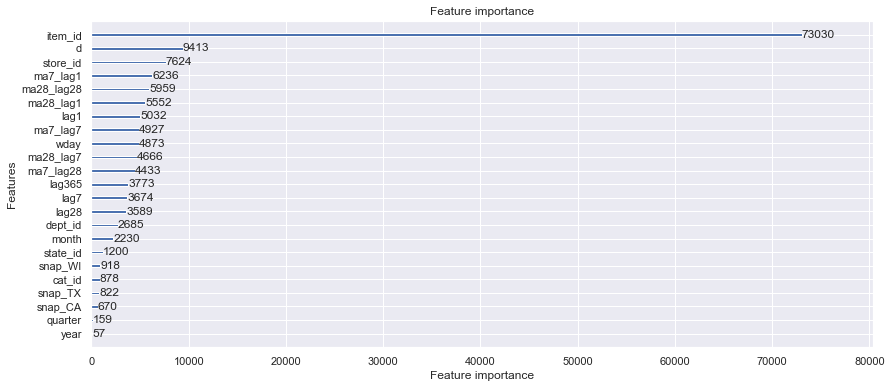

In [56]:
lgb.plot_importance(model)